# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

In [1]:
import numpy as np
import sys
import torch
import torchvision
import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, RandomResizedCrop, AutoAugment
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=0

In [ ]:
!unzip /content/dataset.zip?dl=0 -d sample_data

### Подготовка данных

In [2]:
train_transform = Compose(
    [
     Resize((224,224)),
     #AutoAugment(),
     torchvision.transforms.RandomHorizontalFlip(),
     #torchvision.transforms.RandomVerticalFlip(),
     torchvision.transforms.RandomRotation(45),
     #torchvision.transforms.ColorJitter(brightness=.5, hue=.3),
     ToTensor(),
     Normalize(mean=[0.485, 0.456, 0.406], #вычитала вот тут (https://pytorch.org/vision/stable/models.html) про эти цифры
               std=[0.229, 0.224, 0.225])
    ]
)
val_transform = Compose(
    [
     Resize((224,224)),
     ToTensor(),
     Normalize(mean=[0.485, 0.456, 0.406],
               std=[0.229, 0.224, 0.225])
    ]
)

train_dataset = ImageFolder('../input/homework2/dataset/train/', transform=train_transform)
val_dataset = ImageFolder('../input/homework2/dataset/val/', transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

In [ ]:
import glob
file = np.random.choice(glob.glob("../input/homework2/dataset/train/*/*.jpg"))
plt.imshow(plt.imread(file));

### Вспомогательные функции, реализация модели

In [4]:
from tqdm.notebook import trange, tqdm 
from tqdm.auto import tqdm,trange

In [5]:
import random
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
set_random_seed(50)

### Обучение модели, запуски экспериментов

In [7]:
from torchvision.models import resnet18, vgg16, alexnet

In [8]:
model = resnet18(pretrained=True)
#for param in model.parameters():
#    param.requires_grad = False
model.fc = nn.Linear(512, 200)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
criterion = nn.CrossEntropyLoss()


#optimizer = torch.optim.Adam(model.fc.parameters(), 3e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

n_epochs = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0", return_losses=False):
    model  = model.to(device).train()

    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            accuracy = (predicted.argmax(1) == labels).float().mean()
            
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses == True:
        return metrics, all_losses
    else:
        return metrics
    #pass


def predict(model, val_dataloader, criterion, device="cuda:0"):
    model = model.to(device).eval()

    predicted_classes = np.array([])
    true_classes = np.array([])
    losses = []
    with tqdm(total=len(val_dataloader), file=sys.stdout) as prbar:
         for images, labels in tqdm(val_dataloader):
             images = images.to(device)
             labels = labels.to(device)
             predicted = model(images)
             loss = criterion(predicted, labels)
             accuracy = (predicted.argmax(1) == labels).float().mean()
             
             prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
             )
             prbar.update(1)

             losses.append(loss.detach().item())
             predicted_classes = np.append(predicted_classes, predicted.argmax(1).cpu().detach().numpy())
             true_classes = np.append(true_classes, labels.cpu().detach().numpy())
             
         accuracy_t = accuracy_score(predicted_classes, true_classes)
         print(accuracy_t)
    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs= n_epochs, scheduler=scheduler):
    model.to(device)
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(n_epochs):
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            device = device,
            return_losses=True
        )
        

        # Save Train losses
        print(f"Accuracy: {train_metrics['accuracy']}")
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = predict(
                model=model,
                val_dataloader=val_dataloader,
                criterion=criterion,
                device = device
            )
        # Save eval losses
        epoch_eval_losses.append(np.mean(validation_metrics[0]))
        #scheduler.step(np.sum(validation_metrics[0]))
        scheduler.step(accuracy_score(validation_metrics[1],validation_metrics[2]))
    
    fig = plt.figure()
    plt.plot(range(len(epoch_train_losses)), epoch_train_losses, label='train')
    plt.plot(range(len(epoch_eval_losses)),epoch_eval_losses,label = 'val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

        # Train, evaluate, print accuracy, make a step of scheduler or whatever you want...
    pass

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

In [ ]:
#здесь выкладка показывает итог предпоследнего эксперимента
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler=scheduler)

Train Epoch: 0


  0%|          | 0/1563 [00:00<?, ?it/s]

Accuracy: 0.3123
Validation Epoch: 0


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.557
Train Epoch: 1


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/1563 [00:00<?, ?it/s]

Accuracy: 0.56156
Validation Epoch: 1


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.6488
Train Epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

Accuracy: 0.62757
Validation Epoch: 2


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.6867
Train Epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

Accuracy: 0.66328
Validation Epoch: 3


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.7003
Train Epoch: 4


  0%|          | 0/1563 [00:00<?, ?it/s]

Accuracy: 0.68938
Validation Epoch: 4


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.713
Train Epoch: 5


  0%|          | 0/1563 [00:00<?, ?it/s]

Accuracy: 0.70807
Validation Epoch: 5


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.7218
Train Epoch: 6


  0%|          | 0/1563 [00:00<?, ?it/s]

Accuracy: 0.72586
Validation Epoch: 6


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.7214
Train Epoch: 7


  0%|          | 0/1563 [00:00<?, ?it/s]

Accuracy: 0.74106
Validation Epoch: 7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.722
Train Epoch: 8


  0%|          | 0/1563 [00:00<?, ?it/s]

Accuracy: 0.75444
Validation Epoch: 8


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.7274
Train Epoch: 9


  0%|          | 0/1563 [00:00<?, ?it/s]

Accuracy: 0.76635
Validation Epoch: 9


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.729


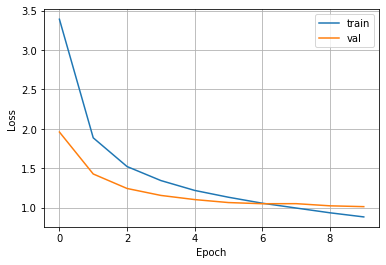

In [11]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler=scheduler)

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [12]:
def evaluate(model, val_dataloader):
    all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(accuracy)

evaluate(model,val_dataloader)

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.729
0.729


In [1]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print(accuracy)

0.729


### Отчёт об экспериментах 

1) претрейн resnet 18 (обучаю последний слой); оптимайзер адам, lr = 1e-4, нормалайз по документации, размер батча 100, без ресайза или аугментаций
качество 0,3437
5 эпох, одна эпоха учится около 5 минут, валидация - около 2 минут

2) добавляю ресайз 224х224
Качество 0,5745

3) добавляю аугментацию autoaugment с дефолтными параметрами, все остальное то же самое; тут я перешла на Kaggle и на GPU обучение одной эпохи составляет порядка 6 минут, валидация - 2 минуты
Качество 0,5415

4) сделала 10 эпох, сократила lr до 3е-4 
Качество 0,598

5) Решила вдохновившись материалом на гитхабе (https://github.com/tjmoon0104/Tiny-ImageNet-Classifier) прогнать всю предобученную модель, а не только последний слой; начала с ресайза без аугментаций; оптимайзер Адам lr = 3e-4, 10 эпох, scheduler ReduceLROnPlateau. 
Качество 0,594. По графику видно, что на валидации качество выходит на плато, в то время как продолжает повышаться на тренировочном датасете, что становится сигналом переобучения и склоняет к поиску оптимальной аугментации для решения этой проблемы.

6) C аугментацией (см. ячейку с даталоадерами) качество модели несколько ухудшилось - увеличилось время на эпоху, модели требуется больше времени на повышение качества

7) Решила попробовать оптимайзер и scheduler как в уже упомянутом материале на гитхабе - SGD и StepLR. Аугментация сохранена
Качество составило 0,729 (график выше)